<a href="https://colab.research.google.com/github/AlexeyTri/Timeseries/blob/main/Lesson_2_Simple_Exponential_Smoothing_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime 
from datetime import datetime, timedelta
import math
import pandas.tseries.offsets as ofs
import warnings as w
from google.colab import files
%matplotlib inline
from IPython.display import Image
import scipy as sc
import sklearn
from sklearn.linear_model import LinearRegression
from matplotlib import gridspec
import seaborn as sns

In [91]:
import os
import numpy as np
import math
import scipy as sc
import matplotlib.pyplot as plt

# Initialized Exponential Smoothing
# x <array Tx1>- pandas time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter
#    AdaptationPeriod <int> - length of Adaptation period in timestamps

def InitExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    AdaptationPeriod=Params['AdaptationPeriod']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    y = x[0]
    t0=0
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(y):
                y=x[t]
                t0=t
            if (t-t0+1)<AdaptationPeriod:
                y = y*(1-alpha*(t-t0+1)/(AdaptationPeriod)) + alpha*(t-t0+1)/(AdaptationPeriod)*x[t]
            y = y*(1-alpha) + alpha*x[t]
            #else do not nothing
        FORECAST[t+h] = y
    return FORECAST	

# Simple Exponential Smoothing
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter
def SimpleExponentialSmoothing(x, h=1, Params={}):
    T = len(x)
    alpha = Params['alpha']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    # initialization
    y = x[0]
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(y):
                y=x[cntr]
            y = alpha*x[cntr] + (1-alpha)*y  # = y + alpha*(x[cntr]-y) 
            #else do not nothing
        FORECAST[cntr+h] = y
    return FORECAST

def HoltExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    beta = Params['beta']
    AdaptationPeriod = Params['AdaptationPeriod']
    
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    if beta>1:
        w.warn('beta can not be more than 1')
        #beta = 1
        return FORECAST
    if beta<0:
        w.warn('beta can not be less than 0')
        #beta = 0
        return FORECAST
    
    
    l= np.NaN
    b= np.NaN
    
    for t in range(T):
        if not math.isnan(x[t]):
            if math.isnan(l):
                l = x[t]
                b = x[t+1]-x[t]
                t0 = np.NaN
                
            l_prev = l    
                        
            if (t-t0+1)<AdaptationPeriod:
                l = (1-(1-alpha)*(t-t0+1)/(AdaptationPeriod))* x[t] + (1-alpha)*(t-t0+1)/(AdaptationPeriod)*(l+b)
                b = (1-beta)*(t-t0+1)/(AdaptationPeriod)*(l - l_prev) + (1-alpha)*(t-t0+1)/(AdaptationPeriod)*b
            else:
                l = alpha* x[t] + (1-alpha)*(l+b)
                b = beta* (l - l_prev) + (1- beta)*b
                # b = beta* (x[t] - l_prev) + (1- beta)*b


        FORECAST[t+h] = l+ b*h
    return FORECAST
	
def AdditiveWintersExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    gamma = Params['gamma']
    p = Params['seasonality_period']
    
    FORECAST = [np.NaN]*(T+h)
    
    l= np.NaN
    s= []
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l= x[cntr]
            if len(s)==0:
                # looking in the future
                for i in range(p):
                    s.append(x[i])
            if cntr<p:
                l = alpha*(x[cntr]-s[cntr])+(1-alpha)*l # recurrent smoothing of level 
            else:
                s.append(gamma*(x[cntr]-l)+(1-gamma)*s[cntr-p])
                l = alpha*(x[cntr]-s[cntr-p])+(1-alpha)*l # recurrent smoothing of level 
                
        FORECAST[cntr+h] = l + s[cntr+h-(1+h//p)*p]
    return FORECAST


def TheilWageExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    beta = Params['beta']
    gamma = Params['gamma']
    p = Params['seasonality_period']
    
    FORECAST = [np.NaN]*(T+h)
    
    l= np.NaN
    b=np.NaN
    s= []
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l= x[cntr]
            if math.isnan(b):
                b= 0
            
            if len(s)==0:
                for i in range(p):
                    s.append(x[i])
                    
                    
            if cntr<p:
                l_old=l
                l = alpha*(x[cntr]-s[cntr])+(1-alpha)*(l+b)
                b=beta*(l-l_old)+(1-beta)*b
            else:
                l_old=l
                s.append(gamma*(x[cntr]-l)+(1-gamma)*s[cntr-p])
                l = alpha*(x[cntr]-s[cntr-p])+(1-alpha)*(l+b) # recurrent smoothing of level 
                b=beta*(l-l_old)+(1-beta)*b
            
        FORECAST[cntr+h] = l+b + s[cntr+h - (1+h//p)*p]
    return FORECAST
	
# AdaptiveExponentialSmoothing
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter
#    AdaptivePeriod scalar> - adapation period for initialization
#    gamma<scalar in [0,1]> - parametr of cross validation
def AdaptiveExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    gamma = Params['gamma']
    AdaptationPeriod=Params['AdaptationPeriod']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    y = np.NaN
    t0= np.NaN
    e1= np.NaN
    e2= np.NaN
    Kt_1 = alpha
    K=alpha
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(y):
                y=x[t]
                t0=t
                e1=alpha
                e2 = 1
            else:
                if (t-t0)<h:
                    e1 = gamma*(x[t]-y)+(1-gamma)*e1
                    e2 = gamma*np.abs(x[t]-y)+(1-gamma)*e2
                else:
                    e1 = gamma*(x[t]-FORECAST[t])+(1-gamma)*e1
                    e2 = gamma*np.abs(x[t]-FORECAST[t])+(1-gamma)*e2
            
            if e2==0:
                K=alpha
            else:
                K=np.abs(e1/e2)

            alpha=Kt_1
            Kt_1=K

            if (t-t0+1)<AdaptationPeriod:
                y = y*(1-alpha)*(t-t0+1)/(AdaptationPeriod) + (1-(1-alpha)*(t-t0+1)/(AdaptationPeriod))*x[t]
            else:
                y = y*(1-alpha) + (alpha)*x[t]
        FORECAST[t+h] = y
    return FORECAST

# generate forecast values based on particular algorithm
# h - forecast horizon, each point in historical period will be forecasted with delay = h (h-step ahead)
# ts - <pandas data frame> with timestamps in index, each column contains particular timeseries, all of them will be forecasted independently
# AlgName - <str> name of the function that runs forecasting algorithm 
# AlgTitle <str> - a name of the forecasting algorithm
# step <char> - aggregation method of the original data before forecasting
# ParamsArray <array> - array of parameter set, each component of array defines particular forecasting algorithm
def build_forecast(h, ts, alg_name, alg_title, params_array, step='D'):
      
	FRC_TS = dict()

	for p in params_array:
		frc_horizon = pd.date_range(ts.index[-1], periods=h+1, freq=step)[1:]
		frc_ts = pd.DataFrame(index = ts.index.append(frc_horizon), columns = ts.columns)
	  
		for cntr in ts.columns:
			frc_ts[cntr] = eval(alg_name)(ts[cntr], h, p)

		#         frc_ts.columns = frc_ts.columns+('%s %s' % (alg_title, p))
		FRC_TS['%s %s' % (alg_title, p)] = frc_ts

	return FRC_TS

# draw forecast and original time series
# ts - <pandas data frame> with timestamps in index, each column contains particular timeseries
# frc_ts - <pandas data frame> the same structure as ts, 
# ts_num <int> - column index for which plot shoud be drawn
# alg_title <str> - a name of the forecasting algorithm
def plot_ts_forecast(ts, frc_ts, ts_num=0, alg_title=''):
	frc_ts.columns = ts.columns+'; '+alg_title
	ts[ts.columns[ts_num]].plot(style='b', linewidth=1.0, marker='o')
	ax = frc_ts[frc_ts.columns[ts_num]].plot(style='r-^', figsize=(25,5), linewidth=1.0)
	plt.xlabel("Time ticks")
	plt.ylabel("TS values")
	plt.legend()
	return ax

# Quality functions
def qualitySSE(x,y):
    # Sum squared error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return ((x-y)**2).sum(), (x-y)**2

def qualityMSE(x,y):
    # Mean squared error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return ((x-y)**2).mean() , (x-y)**2

def qualityRMSE(x,y):
    # Root mean squared error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return (((x-y)**2).mean())**(0.5) , (x-y).abs()

def qualityMAE(x,y):
    # Mean absolute error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return (x-y).abs().mean(), (x-y).abs()

def qualityMAPE(x,y):
    # Mean absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/x.abs()).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , qlt

def qualityMAPPE(x,y):
    # Mean absolute predicted percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/y.abs()).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , qlt

def qualitySMAPE(x,y):
    # Symmetric mean absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = (2*(x-y).abs()/(x+y)).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , qlt

def qualityMAMAXPE(x,y):
    # Mean absolute maximum percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/max(x.abs(), y.max())).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , qlt

def qualityMASE(x,y, init_step=0):
    # Mean absolute scaled error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/(x-x.shift(1)).abs())[init_step:].replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , qlt

def qualityMedianAE(x,y):
    # Median absolute error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return ((x-y).abs()).median(), (x-y).abs()

def qualityWAPE(x,y):
    # Weighted absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    denom = x.abs().sum()
    qlt = ((x-y).abs()/denom).replace([np.inf, -np.inf], np.nan)
    return qlt.sum() , qlt

def qualityWAPPE(x,y):
    # Weighted absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    denom = y.abs().sum()
    qlt = ((x-y).abs()/denom).replace([np.inf, -np.inf], np.nan)
    return qlt.sum() , qlt

def qualityWAMAXPE(x,y):
    # Weighted absolute maximum percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    denom = pd.merge(x, y, right_index = True, left_index = True).max(axis = 1).sum()
    qlt = ((x-y).abs()/denom).replace([np.inf, -np.inf], np.nan)
    return qlt.sum() , qlt

def qualityMedianAE(x,y):
    # Median absolute error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return ((x-y).abs()).median(), (x-y).abs()
	
def get_autoregrmatrix(x,h,K):
    T = len(x)
    X = sc.linalg.hankel(x[:T-h-K+1], 
                          np.hstack((x[T-h-K:T-h]))) # is needed to repeat x[-K] in second part
    y = x[K+h-1:]
    return X,y

# Typical TS for SES Model

## TS in Retail

In [2]:
ts = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/retail_10ts.csv', parse_dates=['Dates'], dayfirst=True, index_col='Dates')
ts.index.names=['Timestamp']
ts = ts.sort_index() # sort index
ts.head()

,Item: 165,Item: 969,Item: 2653,Item: 2654,Item: 2692,Item: 2695,Item: 2697,Item: 2765,Item: 2767,Item: 2806,Item: 2808
Timestamp,,,,,,,,,,,
2005-01-11,NaN,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-12,NaN,5.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-13,NaN,2.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-14,NaN,42.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-15,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Interval of ts 
ts.loc['2007-01-01':'2007-01-05']

,Item: 165,Item: 969,Item: 2653,Item: 2654,Item: 2692,Item: 2695,Item: 2697,Item: 2765,Item: 2767,Item: 2806,Item: 2808
Timestamp,,,,,,,,,,,
2007-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-02,NaN,21.0,11.0,NaN,7.0,2.0,NaN,7.0,1.0,3.0,5.0
2007-01-03,NaN,10.0,15.0,NaN,21.0,7.0,NaN,2.0,3.0,0.0,2.0
2007-01-04,NaN,NaN,4.0,NaN,7.0,NaN,NaN,12.0,1.0,NaN,1.0
2007-01-05,NaN,3.0,36.0,NaN,14.0,NaN,NaN,6.0,10.0,4.0,1.0


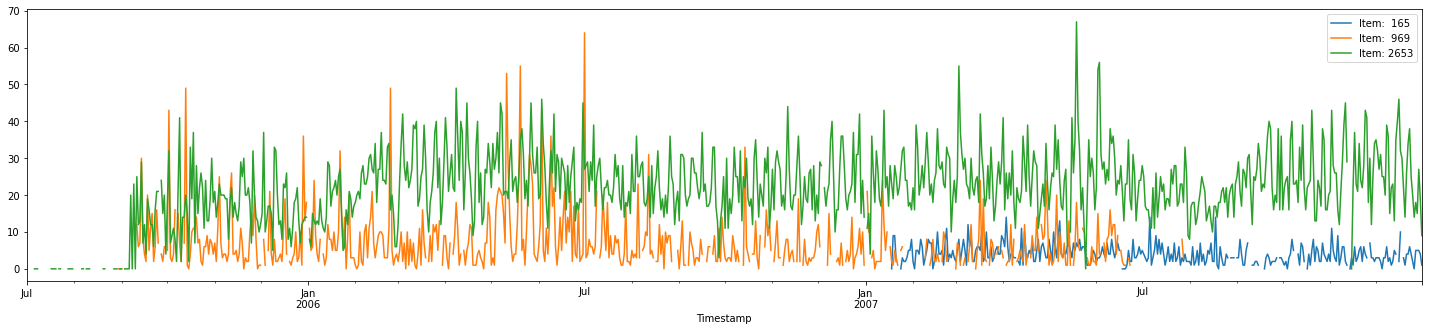

In [5]:
# fig = plt.figure()
ts.loc['2005-07-01':'2007-12-31', ts.columns[range(3)]].plot(figsize=(25,5))
# to save the pictures
plt.savefig('./TS_Example.eps', bbox_inches='tight', pad_inches=0, format='eps', dpi=1000) 

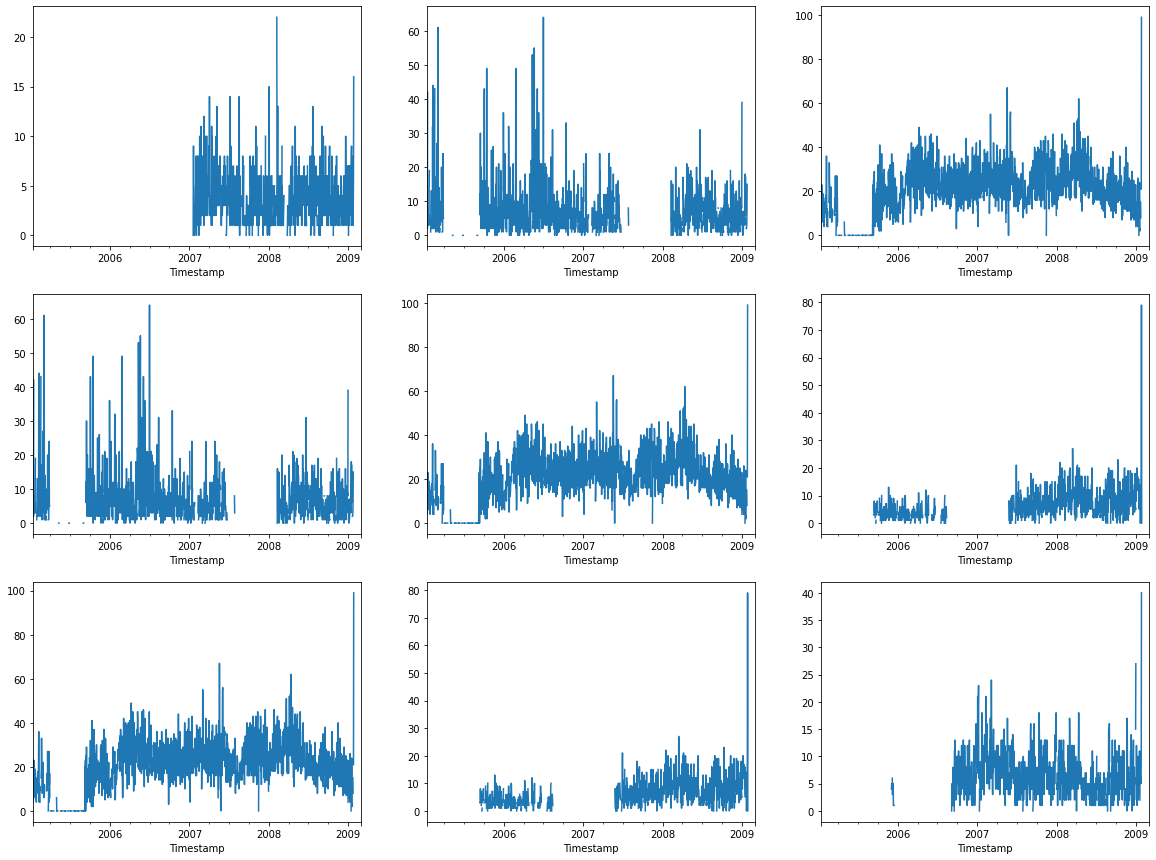

In [8]:
fig = plt.figure(figsize=(20,15))
gs = gridspec.GridSpec(3,3)

for i in range(3):
    for j in range(3):
        fig.add_subplot(gs[i,j])
        ts.loc[:, ts.columns[i+j]].plot()

Questions

Any idea how to predict such ts?
Can you describe statistical model for such ts?
Answer

$y_t = l_t + 𝛆_t$

$l_t$ - changing slowly level of time series,

$𝛆_t$ - error component (unobserved noise)

Forecasting model:

$\hat y_{t+d} = \hat l_t$

$\hat l_t$ - an estimation of level

## Moving Average
Скользящая средняя

Rolling window n

$\hat y_{t+d} = \frac{1}{n}(y_{t-n+1}+ ...+ y_t)$

All points in $[t-n+1, t]$ has the same weight

$w=\frac{1}{n}$

Other points has weight

$w=0$

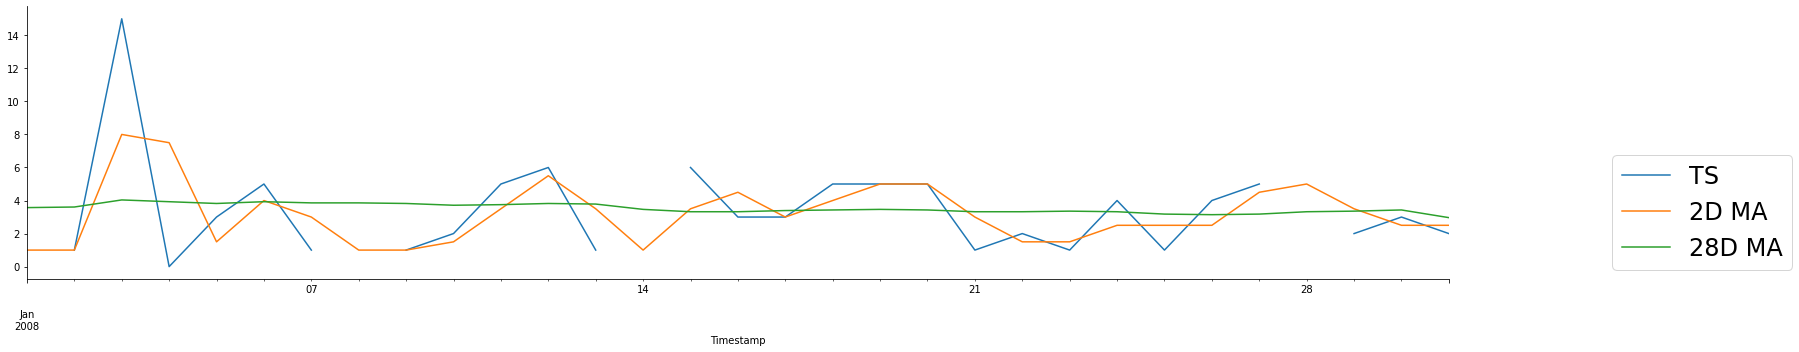

In [10]:
# Rolling moving (n = 2 и n=28)
ts.loc['2008-01-01':'2008-01-31']['Item:  165'].plot(label='TS')
# pad - заполнение пустот последним нашим значением
# rolling - расчет окна сглаживания по конретному столбцу
ts['Item:  165'].fillna(method='pad').rolling(2).mean().loc['2008-01-01':'2008-01-31'].plot(label='2D MA', figsize=(25,5))
ts['Item:  165'].fillna(method='pad').rolling(28).mean().loc['2008-01-01':'2008-01-31'].plot(label='28D MA', figsize=(25,5))

plt.legend(bbox_to_anchor=(1.25, .5), prop={'size': 24})
plt.tight_layout()
sns.despine()

Expanding window

$\hat y_{t+d} = \frac{1}{t}(y_1+...+y_t)$

All time points in $[1, t]$  has the same weight

$w=\frac{1}{n}$



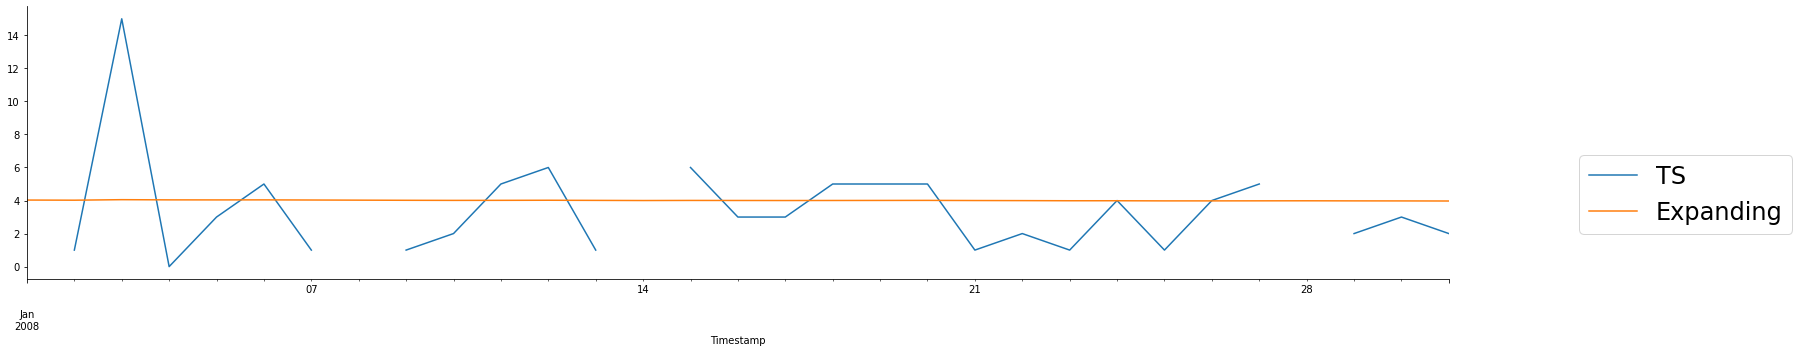

In [11]:
# Expanding windod
ts.loc['2008-01-01':'2008-01-31'][u'Item:  165'].plot(label='TS')
ts.fillna(method='pad')[u'Item:  165'].expanding().mean().loc['2008-01-01':'2008-01-31'].plot(label='Expanding', figsize=(25,5))

plt.legend(bbox_to_anchor=(1.25, .5), prop={'size':24})
plt.tight_layout()
sns.despine()

# Exponentially Wighted Moving Average
Простое экспоненциальное сглаживаниеэкспоненциально заниженная скользящая средняя

Exponentialy diminishing weights

$\hat y_{t+d} = αy_t + α(1-α)y_{t-1} + α(1-α)^2y_{t-2} +...= \sum_{τ=1}^t α(1-α)^{t-τ}\cdot y_τ$


Exponentialy diminishing weights

Weight for time point in moment $τ$

$w_τ = α(1-α)^{t-τ}$

In [13]:
# look at timestamp weights
t = 10
alpha_set = [0.001, 0.1, 0.15, 0.2, 0.5, 0.9]
pd.DataFrame(data = [[a*(1-a)**(t-tau) for a in alpha_set] for tau in range(1,t+1,1)], columns = [r'\alpha=' + str(x) for x in alpha_set], index = range(t))

,\alpha=0.001,\alpha=0.1,\alpha=0.15,\alpha=0.2,\alpha=0.5,\alpha=0.9
0,0.000991,0.038742,0.034743,0.026844,0.000977,9.000000e-10
1,0.000992,0.043047,0.040874,0.033554,0.001953,9.000000e-09
2,0.000993,0.047830,0.048087,0.041943,0.003906,9.000000e-08
3,0.000994,0.053144,0.056572,0.052429,0.007812,9.000000e-07
4,0.000995,0.059049,0.066556,0.065536,0.015625,9.000000e-06
5,0.000996,0.065610,0.078301,0.081920,0.031250,9.000000e-05
6,0.000997,0.072900,0.092119,0.102400,0.062500,9.000000e-04
7,0.000998,0.081000,0.108375,0.128000,0.125000,9.000000e-03
8,0.000999,0.090000,0.127500,0.160000,0.250000,9.000000e-02
9,0.001000,0.100000,0.150000,0.200000,0.500000,9.000000e-01


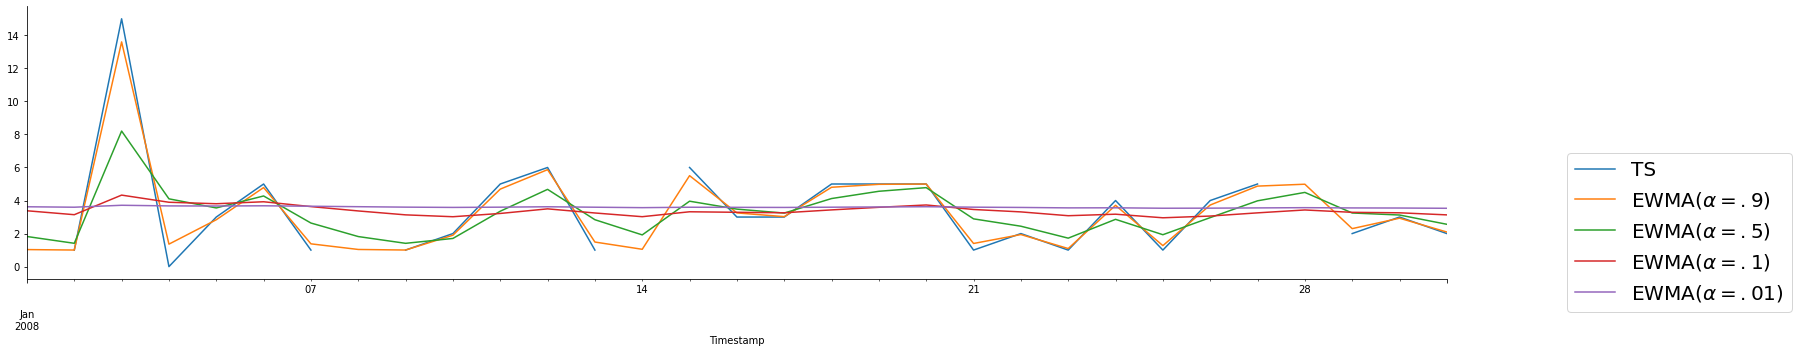

In [14]:
# Averaging with exponential weights
ts.loc['2008-01-01':'2008-01-31'][u'Item:  165'].plot(label='TS')
ts.fillna(method='pad')[u'Item:  165'].ewm(alpha=0.9).mean().loc['2008-01-01':'2008-01-31'].plot(label='EWMA($\\alpha=.9$)') 
ts.fillna(method='pad')[u'Item:  165'].ewm(alpha=0.5).mean().loc['2008-01-01':'2008-01-31'].plot(label='EWMA($\\alpha=.5$)') 
ts.fillna(method='pad')[u'Item:  165'].ewm(alpha=0.1).mean().loc['2008-01-01':'2008-01-31'].plot(label='EWMA($\\alpha=.1$)') 
ts.fillna(method='pad')[u'Item:  165'].ewm(alpha=0.01).mean().loc['2008-01-01':'2008-01-31'].plot(label='EWMA($\\alpha=.01$)', figsize=(25,5)) 

plt.legend(bbox_to_anchor=(1.25, .5), prop={'size':20})
plt.tight_layout()
sns.despine()

Parameter $α$ drives the depth of the historical period to be considered!

$α ⇑ 1 ⇒ $ EWMA is closer to Moving Average with window = 1,


$α ⇓ 0 ⇒ $ EWMA is closer to Moving Average with expanding window.

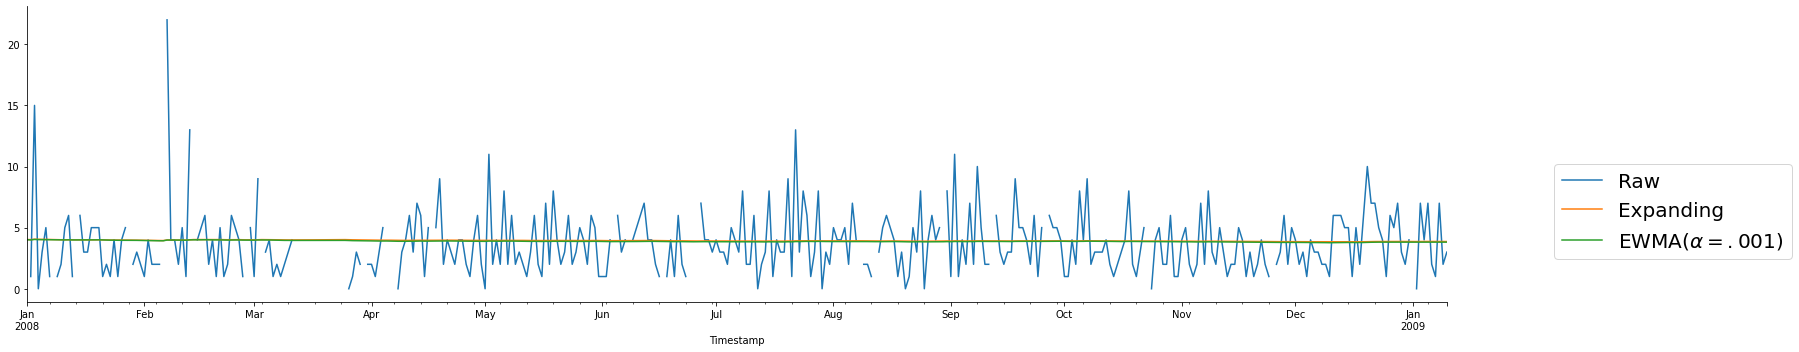

In [15]:
# Compare EWMA (alpha = 0.001) and Expanding 
ts.loc['2008-01-01':'2009-01-10'][u'Item:  165'].plot(label='Raw')
ts[u'Item:  165'].fillna(method='pad').expanding().mean().loc['2008-01-01':'2009-01-10'].plot(label='Expanding')
ts[u'Item:  165'].ewm(alpha=0.001).mean().loc['2008-01-01':'2009-01-10'].plot(label='EWMA($\\alpha=.001$)', figsize=(25,5)) 

plt.legend(bbox_to_anchor=(1.25, .5), prop={'size':20})
plt.tight_layout()
sns.despine()

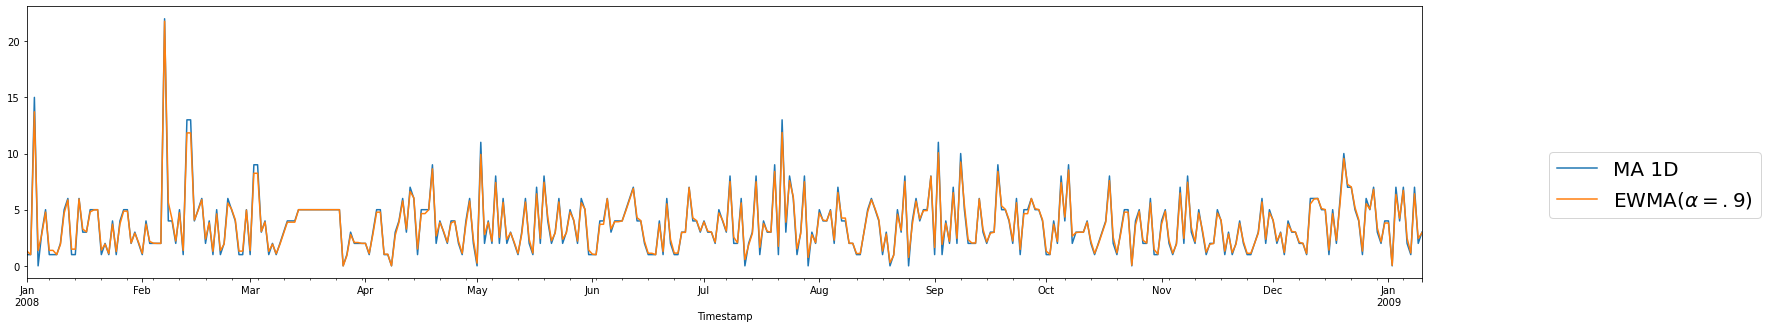

In [16]:
# Compare EWMA (alpha = 0.9) and MA (window = 1) 
# ts.loc['2008-01-01':'2009-01-10'][u'Item:  165'].plot(label='Raw')
ts[u'Item:  165'].fillna(method='pad').rolling(1).mean().loc['2008-01-01':'2009-01-10'].plot(label='MA 1D')
ts[u'Item:  165'].ewm(alpha=0.9).mean().loc['2008-01-01':'2009-01-10'].plot(label='EWMA($\\alpha=.9$)', figsize=(25,5)) 
plt.legend(bbox_to_anchor=(1.25, .5), prop={'size':20})

# Simple Exponential Smoothing


$\hat y_{t+d} = \sum_{τ=1}^t α(1-α)^{t-τ}\cdot y_τ$

Recurrent formula notation:

$\hat y_{t+d} = αy_t + α(1-α)\hat y_{t} = \hat y_t + α\epsilon_t$

$\epsilon_t = y_t - \hat y_t$

In [18]:
# Example of realization

# Simple Exponential Smoothing
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter
def SimpleExponentialSmoothing(x, h=1, Params={}):
    T = len(x)
    alpha = Params['alpha']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    # initialization
    y = x[0]
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(y):
                y=x[cntr]
            y = alpha*x[cntr] + (1-alpha)*y  # = y + alpha*(x[cntr]-y) 
            #else do not nothing
        FORECAST[cntr+h] = y
    return FORECAST

In [19]:
# Forecast delay = 1
h = 1
start = ts.index[-1]+timedelta(1) #предпоследний день
end = ts.index[-1]+timedelta(h) # последний участок
rng = pd.date_range(start, end)
frc_ts = pd.DataFrame(index = ts.index.append(rng), columns = ts.columns)

In [20]:
# ES params
Params ={'alpha':0.1}

# generate forecasts for each Item
for cntr in ts.columns:
    frc_ts[cntr] = SimpleExponentialSmoothing(ts[cntr], h, Params)

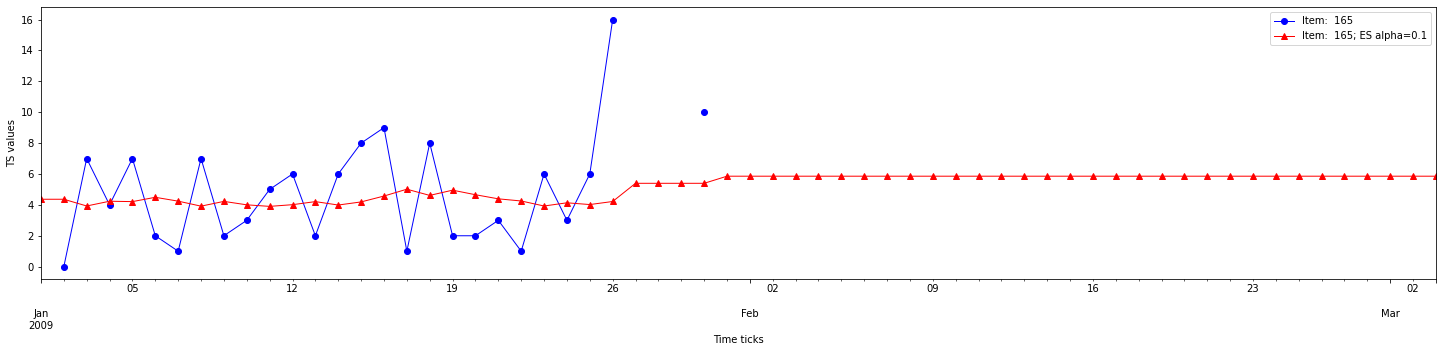

In [21]:
# show SES forecast alpha = 0.1
def plotTSForecast(ts, frc_ts, ts_num=0, alg_title=''):
    frc_ts.columns = ts.columns+'; '+alg_title
    ts[ts.columns[0]].plot(style='b', linewidth=1.0, marker='o')
    ax = frc_ts[frc_ts.columns[ts_num]].plot(style='r-^', figsize=(25,5), linewidth=1.0)
    plt.xlabel("Time ticks")
    plt.ylabel("TS values")
    plt.legend()
    return ax

plotTSForecast(ts.loc['2009-01-01':'2009-03-03'], frc_ts.loc['2009-01-01':'2009-03-03'], ts_num=0, alg_title='ES alpha=0.1')

In [22]:
# Generate forecast for h = 30
h = 30
start = ts.index[-1]+timedelta(1)
end = ts.index[-1]+timedelta(h)
rng = pd.date_range(start, end)
frc_ts = pd.DataFrame(index = ts.index.append(rng), columns = ts.columns)

for cntr in ts.columns:
    frc_ts[cntr] = SimpleExponentialSmoothing(ts[cntr], h, {'alpha':0.1})

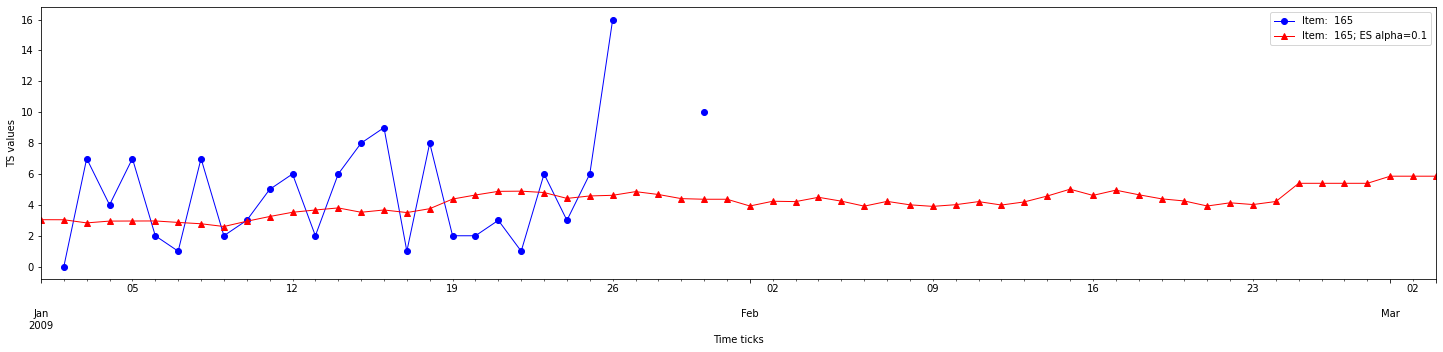

In [23]:
# show forecast h = 30, alpha = 0.1
plotTSForecast(ts.loc['2009-01-01':'2009-03-03'], frc_ts.loc['2009-01-01':'2009-03-03'], ts_num=0, alg_title='ES alpha=0.1')

Search for the optimal $α$

PIPLInE выбора гиперпараметров

In [24]:
def build_forecast(h, ts, AlgName, AlgTitle, ParamsArray, step='D'):
  'grid'
    
  FRC_TS = dict()

  for p in ParamsArray:
      frc_horizon = pd.date_range(ts.index[-1], periods=h+1, freq=step)[1:] # горизонт предсказания, частотное распределение
      frc_ts = pd.DataFrame(index = ts.index.append(frc_horizon), columns = ts.columns) # весь временной ряд
      
      for cntr in ts.columns:
          frc_ts[cntr] = eval(AlgName)(ts[cntr], h, p)
          # frc_ts[cntr] = AlgName(ts[cntr], h, p)
      
#         frc_ts.columns = frc_ts.columns+('%s %s' % (AlgTitle, p))
      FRC_TS['%s %s' % (AlgTitle, p)] = frc_ts
  
  return FRC_TS

In [25]:
#Fit parameters
ALPHA = [0.7, 0.4, 0.2, .15, 0.1, 0.05, 0.01]
ESParamsArray = [{'alpha':alpha} for alpha in ALPHA]
FRC_TS = build_forecast(h=1, ts=ts, AlgName =  'SimpleExponentialSmoothing', AlgTitle='ES' ,ParamsArray = ESParamsArray)

Loss of the SES forecast for all history

In [26]:
# intoduce loss function
def qualityMAPE(x,y):
    # Mean absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
  qlt = ((x-y).abs()/x).replace([np.inf, -np.inf], np.nan)
  return qlt.mean() , (x-y).abs()

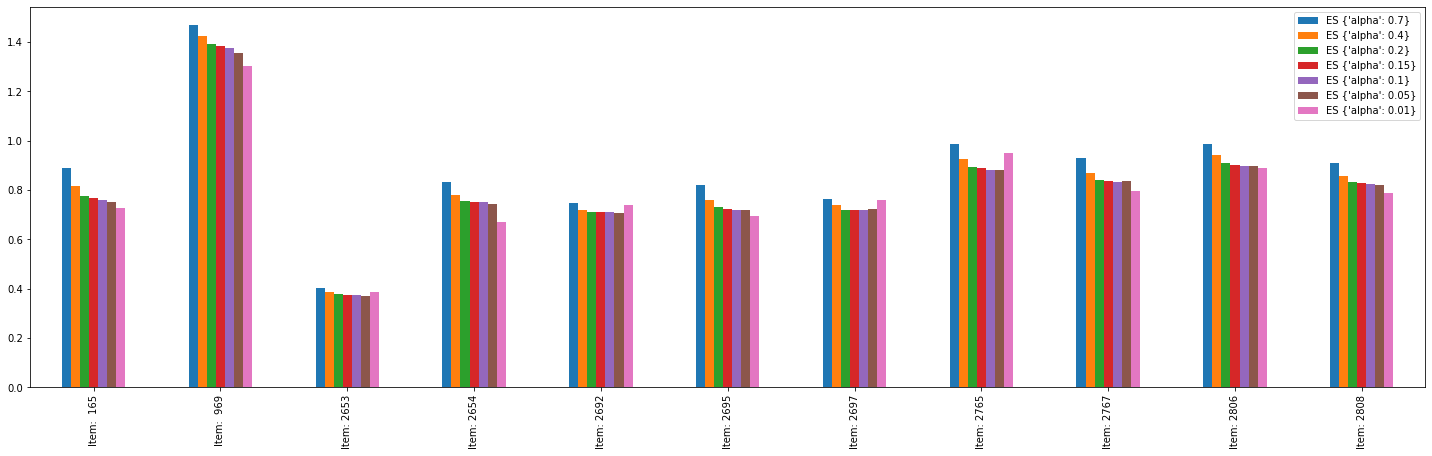

In [27]:
# compare ES parameters
quality_wholehist = pd.DataFrame(index = ts.columns, columns = FRC_TS.keys())

# Quality within all 1500 steps
for param_cntr in sorted(quality_wholehist.columns):
    frc_ts = FRC_TS[param_cntr]
    quality_wholehist[param_cntr],_ = qualityMAPE(ts, frc_ts.loc[ts.index])

ax = quality_wholehist.plot.bar(figsize = (25,7))

Loss for first time series point

Text(0, 0.5, 'MAPE')

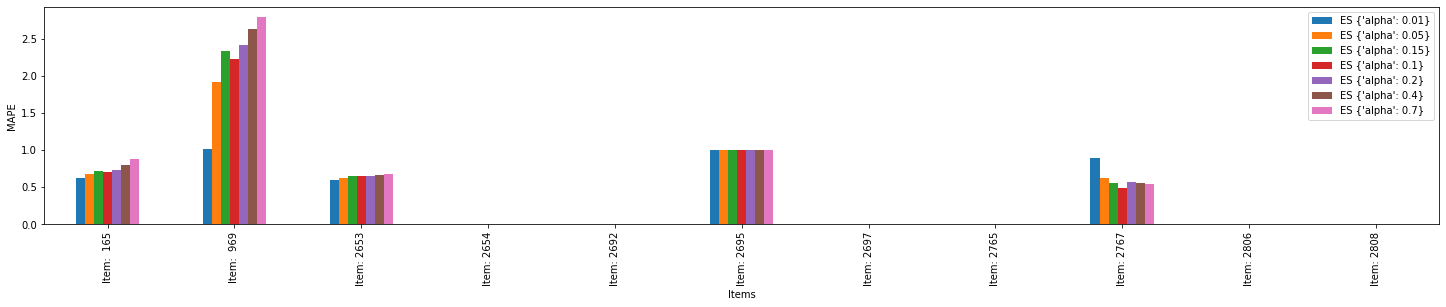

In [28]:
quality_initphase = pd.DataFrame(index = ts.columns, columns = FRC_TS.keys())

# Quality in first 100 steps
init_steps = 100
for model in quality_initphase.columns:
    frc_ts = FRC_TS[model]
    for ts_num in ts.columns:
        ix = pd.date_range(ts[ts_num].first_valid_index(), ts[ts_num].first_valid_index()+timedelta(init_steps))
        quality_initphase[model][ts_num],_ = qualityMAPE(ts[ts_num].loc[ix], frc_ts[ts_num].loc[ix])

ax = quality_initphase[sorted(quality_initphase.columns)].plot.bar(figsize = (25,4))
ax.set_xlabel("Items")
ax.set_ylabel("MAPE")

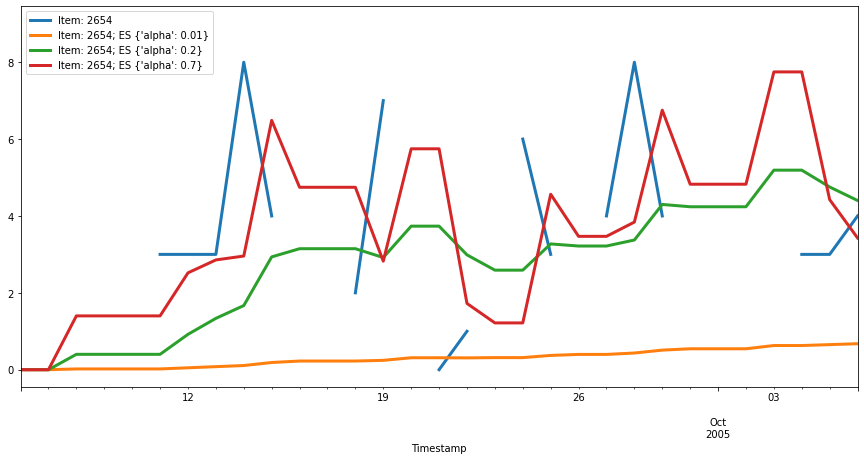

In [29]:
# ts VS forecast in first 100 steps
model_num = [0,4,6]  # [0,6], [0,4,6]
Models = sorted(FRC_TS.keys())

ts_num = 3 # 7
plot_ts = pd.DataFrame(index =ts.index)
plot_ts[ts.columns[ts_num]] = ts[ts.columns[ts_num]]
for model in model_num:
     frc_ts = FRC_TS[Models[model]]
     plot_ts[frc_ts.columns[ts_num]+'; '+Models[model]] = frc_ts[frc_ts.columns[ts_num]]

ix = pd.date_range(ts[ts.columns[ts_num]].first_valid_index()+timedelta(140), ts[ts.columns[ts_num]].first_valid_index()+timedelta(170))
plot_ts.loc[ix].plot(figsize = (15, 7), linewidth=3.0) # :250

# Examples of modification (self-study)

In [30]:
def InitExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    AdaptationPeriod=Params['AdaptationPeriod']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    y = x[0]
    t0=0
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(y):
                y=x[t]
                t0=t
            if (t-t0+1)<AdaptationPeriod:
                y = y*(1-alpha)*(t-t0+1)/(AdaptationPeriod) + (1-(1-alpha)*(t-t0+1)/(AdaptationPeriod))*x[t]
            else:
                y = y*(1-alpha) + alpha*x[t]
            #else do not nothing
        FORECAST[t+h] = y
    return FORECAST

Second variant: normalize weights

In [31]:
def NormExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    
    y = 0
    norm = 0
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(y):
                norm=1  # initialize when first data point comes
            norm = norm*(1-alpha)
            y = y*(1-alpha) + (alpha)*x[t]
        FORECAST[t+h] = y/(1-norm)
    return FORECAST

In [32]:

#Fit parameters

ALPHA = [0.7, 0.4, 0.2, .15, 0.1, 0.05, 0.01]
ESParamsArray = [{'alpha':alpha, 'AdaptationPeriod': 5} for alpha in ALPHA]
FRC_TS.update(build_forecast(h=1, ts=ts, AlgName =  'InitExponentialSmoothing', AlgTitle='IES' ,ParamsArray = ESParamsArray))
FRC_TS.update(build_forecast(h=1, ts=ts, AlgName =  'NormExponentialSmoothing', AlgTitle='NES' ,ParamsArray = ESParamsArray))

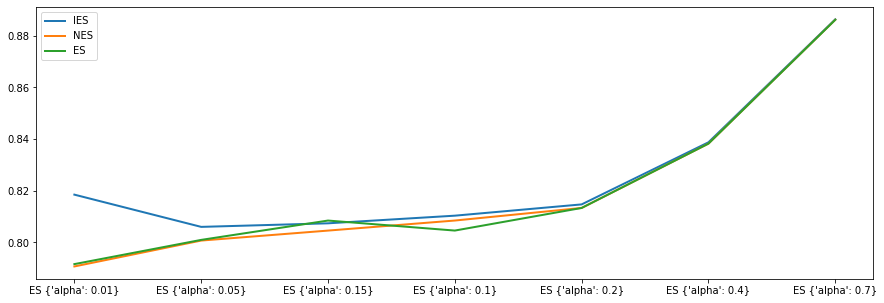

In [33]:
# compare ES methods
QualityStr = pd.DataFrame(index = ts.columns, columns = sorted(FRC_TS.keys()))

for model in sorted(QualityStr.columns):
    frc_ts = FRC_TS[model]
    QualityStr[model],_ = qualityMAPE(ts, frc_ts)


QualityStr[sorted(QualityStr.columns)[7:14]].mean().plot(label='IES', linewidth=2.0)
QualityStr[sorted(QualityStr.columns)[14:]].mean().plot(label='NES', linewidth=2.0)
QualityStr[sorted(QualityStr.columns)[:7]].mean().plot(label='ES', figsize = (15, 5),linewidth=2.0)
# ax.set_xticklabels(np.reshape(np.asarray(QualityStr.columns[:14]), (2, 7)).T , rotation=90)
plt.legend()

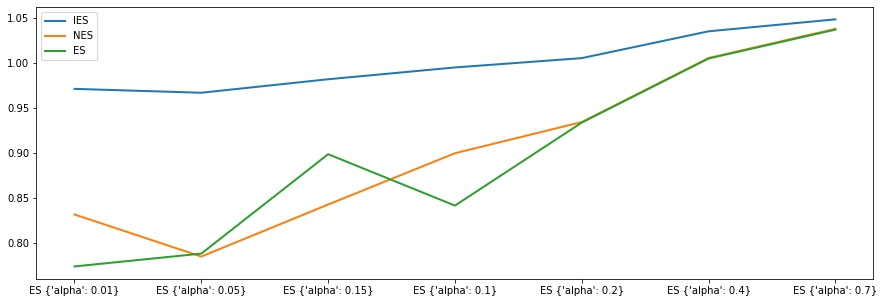

In [34]:
# compare ES methods in first 100 steps
QualityStr = pd.DataFrame(index = ts.columns, columns = sorted(FRC_TS.keys()))

for model in QualityStr.columns:
    frc_ts = FRC_TS[model]
    for ts_num in ts.columns:
        ix = pd.date_range(ts[ts_num].first_valid_index(), ts[ts_num].first_valid_index()+timedelta(50))
        QualityStr[model][ts_num],_ = qualityMAPE(ts[ts_num].loc[ix], frc_ts[ts_num].loc[ix])


QualityStr[sorted(QualityStr.columns)[7:14]].mean().plot(label='IES', linewidth=2.0)
QualityStr[sorted(QualityStr.columns)[14:21]].mean().plot(label='NES', linewidth=2.0)
QualityStr[sorted(QualityStr.columns)[:7]].mean().plot(label='ES',  figsize = (15, 5),linewidth=2.0)
plt.legend()